# NAIVE BAYES: Prediccion de dianósticos de SOP en mujeres.
## Resumen del dataset

El dataset contiene 1000 registros con 6 variables relacionadas con el diagnóstico de SOP:

    Age: Edad de las pacientes (18-45 años)

    BMI: Índice de masa corporal (18-45)

    Menstrual_Irregularity: Regularidad menstrual (0=No regular, 1=Regular)

    Testosterone_level(ng/dL): Nivel de testosterona (20-100 ng/dL)

    Antral_Follicle_Count: Conteo de folículos antrales (5-30)

    PCOS_Diagnosis: Diagnóstico de SOP (0=Negativo, 1=Positivo)

In [1]:
#Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools
pio.renderers.default = 'colab'
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
     

In [3]:
data=pd.read_csv('pcos_dataset.csv')
print(f'data.shape: {data.shape}')
data.head()

data.shape: (1000, 6)


,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,35,1,25,20,0
1,37,26,0,57,25,0
2,32,24,0,93,28,0
3,28,29,0,63,26,0
4,25,22,1,60,8,0


# Visualización de Dataset

In [4]:
df=pd.DataFrame(data)
df

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,35,1,25,20,0
1,37,26,0,57,25,0
2,32,24,0,93,28,0
3,28,29,0,63,26,0
4,25,22,1,60,8,0
...,...,...,...,...,...,...
995,34,18,1,96,23,0
996,45,29,1,29,7,0
997,37,28,0,32,28,0
998,41,27,0,96,9,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        1000 non-null   int64
 1   BMI                        1000 non-null   int64
 2   Menstrual_Irregularity     1000 non-null   int64
 3   Testosterone_Level(ng/dL)  1000 non-null   int64
 4   Antral_Follicle_Count      1000 non-null   int64
 5   PCOS_Diagnosis             1000 non-null   int64
dtypes: int64(6)
memory usage: 47.0 KB


# Preparación del Dataset

In [6]:
df.isnull().sum().to_frame('NaN Value').T

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
NaN Value,0,0,0,0,0,0


In [7]:
for col in df:
  print(f"{col}: {df[col].nunique()}")

Age: 28
BMI: 18
Menstrual_Irregularity: 2
Testosterone_Level(ng/dL): 81
Antral_Follicle_Count: 25
PCOS_Diagnosis: 2


In [8]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,31.771,8.463462,18.0,24.0,32.0,39.00,45.0
BMI,1000.0,26.452,4.960272,18.0,22.0,26.0,31.00,35.0
Menstrual_Irregularity,1000.0,0.520,0.499850,0.0,0.0,1.0,1.00,1.0
Testosterone_Level(ng/dL),1000.0,60.216,23.175600,20.0,42.0,60.0,80.00,100.0
Antral_Follicle_Count,1000.0,17.469,7.069301,5.0,12.0,18.0,23.25,29.0
PCOS_Diagnosis,1000.0,0.199,0.399448,0.0,0.0,0.0,0.00,1.0


# Análisis exploratorio de datos (EDA)

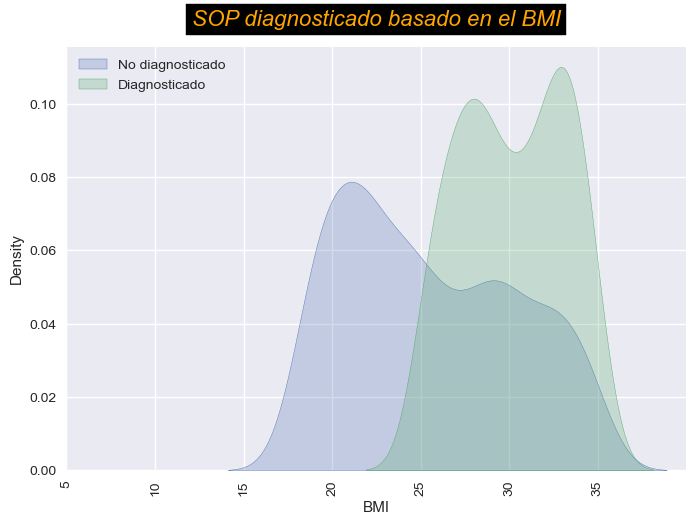

In [9]:
#Revisar el BMI (basado en diagnostico)
import warnings
warnings.filterwarnings('ignore')
font={'fontsize':16, 'fontstyle':'italic', 'backgroundcolor': 'black', 'color':'orange'}
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==0, 'BMI'], label='No diagnosticado', shade=True)
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==1, 'BMI'], label='Diagnosticado', shade=True)
plt.title('SOP diagnosticado basado en el BMI', fontdict=font, pad=15)
plt.xticks(np.arange(5,40,5), rotation=90)
plt.xlim([5,40])
plt.legend()
plt.show()
     

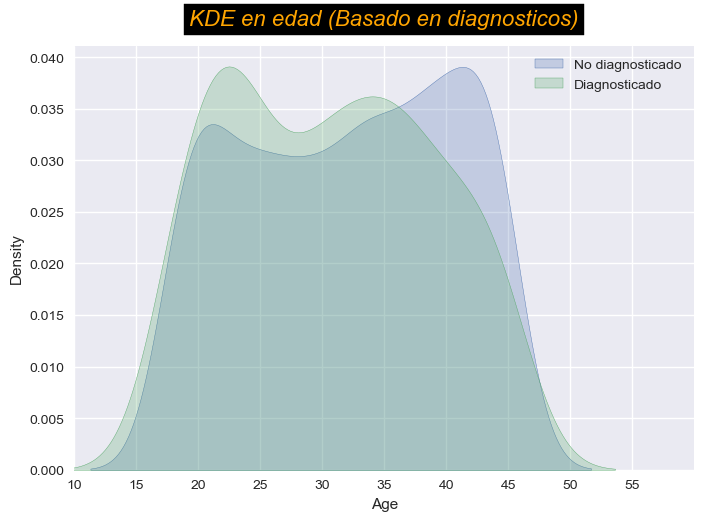

In [10]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==0, 'Age'], label='No diagnosticado', shade=True)
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==1, 'Age'], label='Diagnosticado', shade=True)
plt.title('KDE en edad (Basado en diagnosticos)', fontdict=font, pad=15)
plt.xticks(np.arange(0,60,5))
plt.xlim([10,60])
plt.legend()
plt.show()

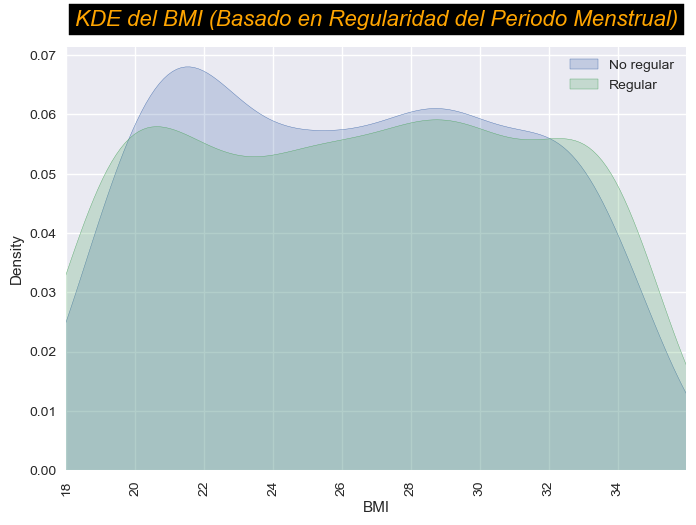

In [11]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Menstrual_Irregularity']==0, 'BMI'], label='No regular', shade=True)
sns.kdeplot(df.loc[df['Menstrual_Irregularity']==1, 'BMI'], label='Regular', shade=True)
plt.title('KDE del BMI (Basado en Regularidad del Periodo Menstrual)', fontdict=font, pad=15)
plt.xticks(np.arange(18,36,2), rotation=90)
plt.xlim([18,36])
plt.legend()
plt.show()

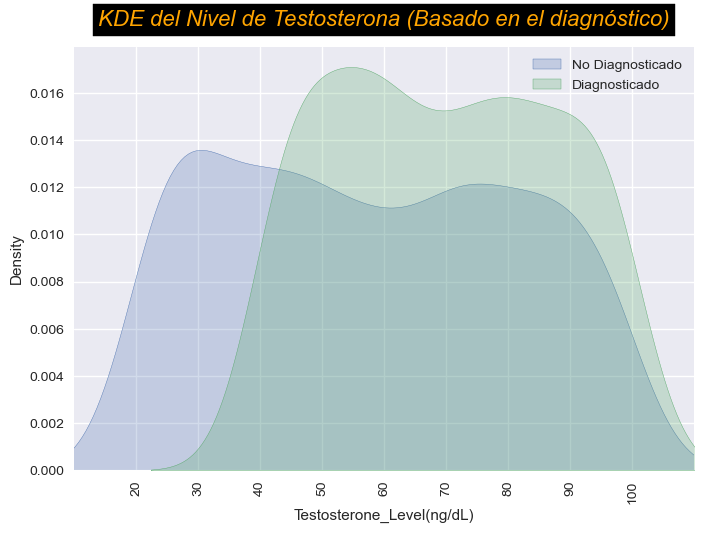

In [12]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==0, 'Testosterone_Level(ng/dL)'], label='No Diagnosticado', shade=True)
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==1, 'Testosterone_Level(ng/dL)'], label='Diagnosticado', shade=True)
plt.title('KDE del Nivel de Testosterona (Basado en el diagnóstico)', fontdict=font, pad=15)
plt.xticks(np.arange(20,101,10), rotation=90)
plt.xlim([10,110])
plt.legend()
plt.show()

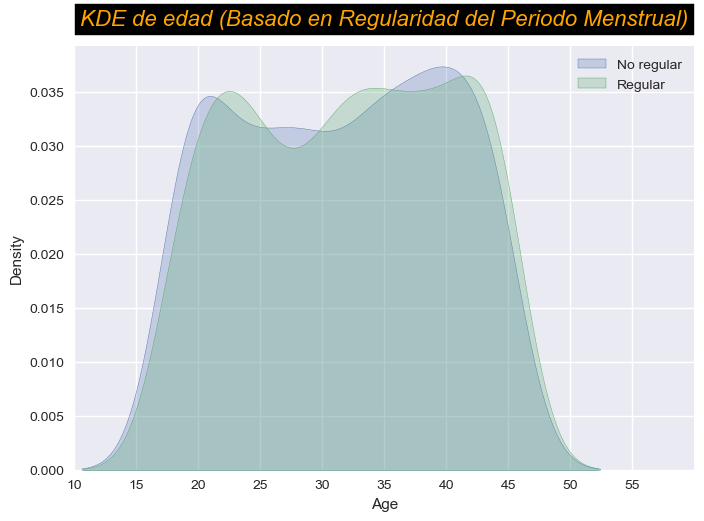

In [13]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Menstrual_Irregularity']==0, 'Age'], label='No regular', shade=True)
sns.kdeplot(df.loc[df['Menstrual_Irregularity']==1, 'Age'], label='Regular', shade=True)
plt.title('KDE de edad (Basado en Regularidad del Periodo Menstrual)', fontdict=font, pad=15)
plt.xticks(np.arange(0,60,5))
plt.xlim([10,60])
plt.legend()
plt.show()

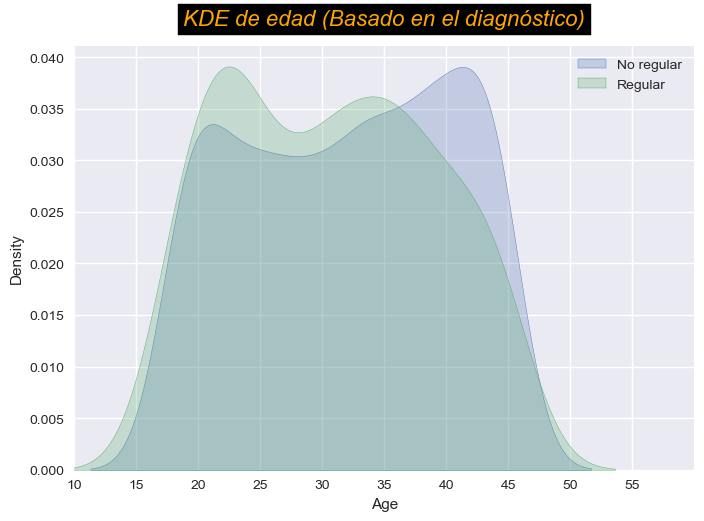

In [14]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==0, 'Age'], label='No regular', shade=True)
sns.kdeplot(df.loc[df['PCOS_Diagnosis']==1, 'Age'], label='Regular', shade=True)
plt.title('KDE de edad (Basado en el diagnóstico)', fontdict=font, pad=15)
plt.xticks(np.arange(0,60,5))
plt.xlim([10,60])
plt.legend()
plt.show()

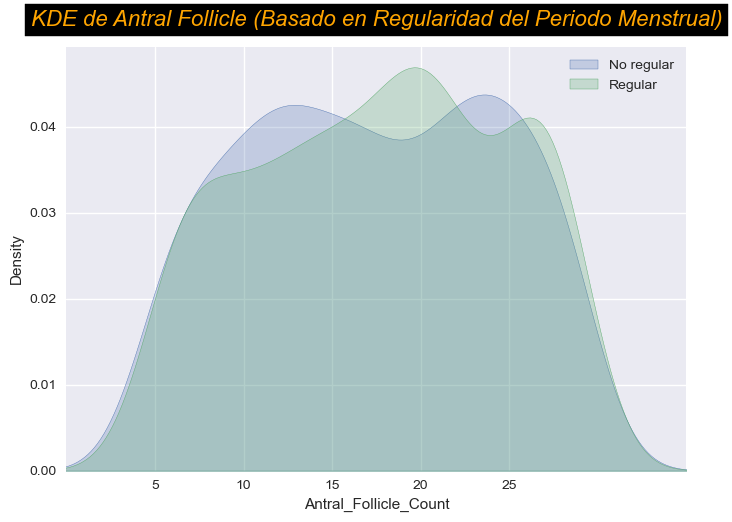

In [15]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Menstrual_Irregularity']==0, 'Antral_Follicle_Count'], label='No regular', shade=True)
sns.kdeplot(df.loc[df['Menstrual_Irregularity']==1, 'Antral_Follicle_Count'], label='Regular', shade=True)
plt.title('KDE de Antral Follicle (Basado en Regularidad del Periodo Menstrual)', fontdict=font, pad=15)
plt.xticks(np.arange(5,30,5))
plt.xlim([0,35])
plt.legend()
plt.show()

## Análisis univariable

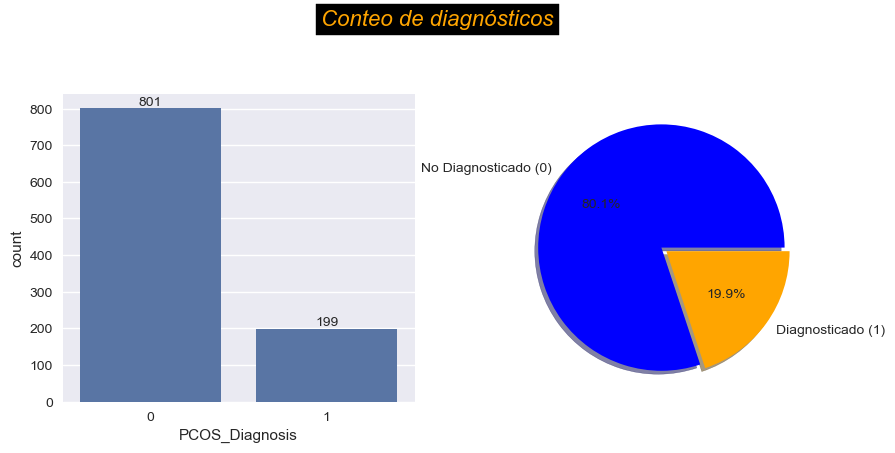

In [16]:

%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.countplot(data=df, x='PCOS_Diagnosis', ax=axes[0])
for container in axes[0].containers:
  axes[0].bar_label(container)
slices = df.PCOS_Diagnosis.value_counts().values
activities = ['No Diagnosticado (0)', 'Diagnosticado (1)']
axes[1].pie(slices, labels=activities, colors=['blue', 'orange'], shadow=True, explode=[0,0.05], autopct='%1.1f%%')
plt.suptitle('Conteo de diagnósticos', y=1.09, **font)
plt.show()

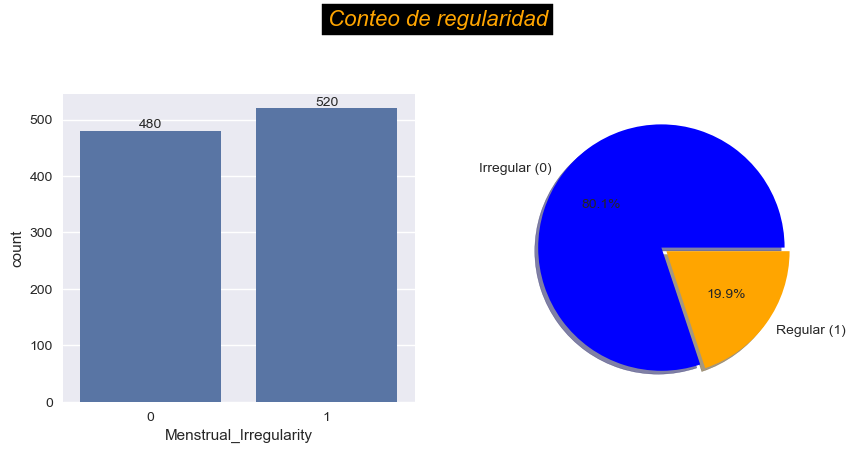

In [17]:

%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.countplot(data=df, x='Menstrual_Irregularity', ax=axes[0])
for container in axes[0].containers:
  axes[0].bar_label(container)
slices = df.PCOS_Diagnosis.value_counts().values
activities = ['Irregular (0)', 'Regular (1)']
axes[1].pie(slices, labels=activities, colors=['blue', 'orange'], shadow=True, explode=[0,0.05], autopct='%1.1f%%')
plt.suptitle('Conteo de regularidad', y=1.09, **font)
plt.show()
     

## Análisis Bivariable.

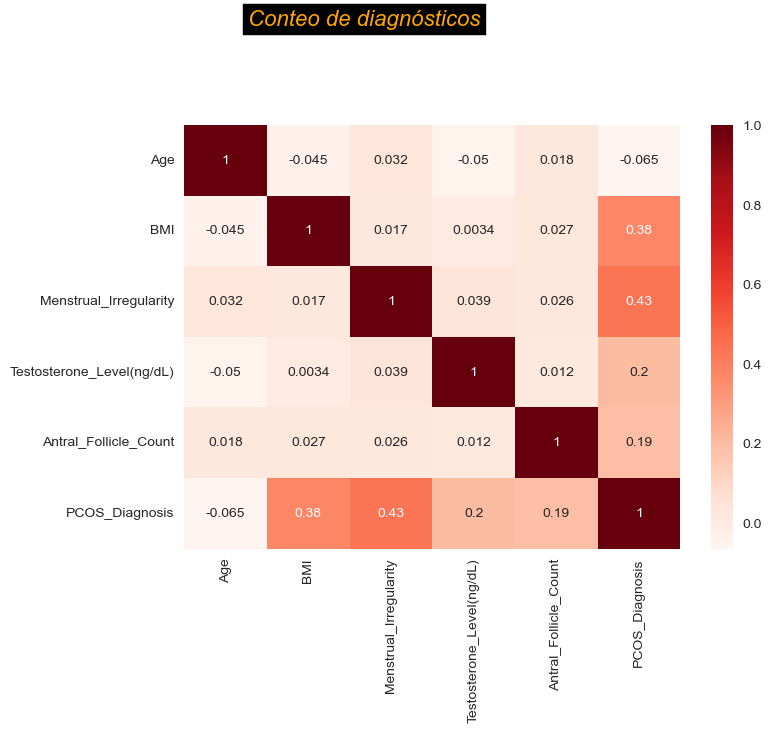

In [18]:
%matplotlib inline
sns.heatmap(df.corr(), cmap='Reds', annot=True)
plt.suptitle('Conteo de diagnósticos', y=1.09, x=0.35, **font)
plt.show()

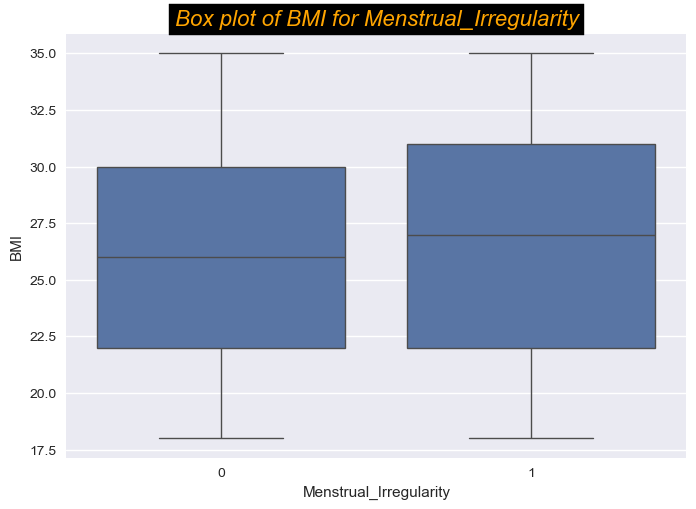

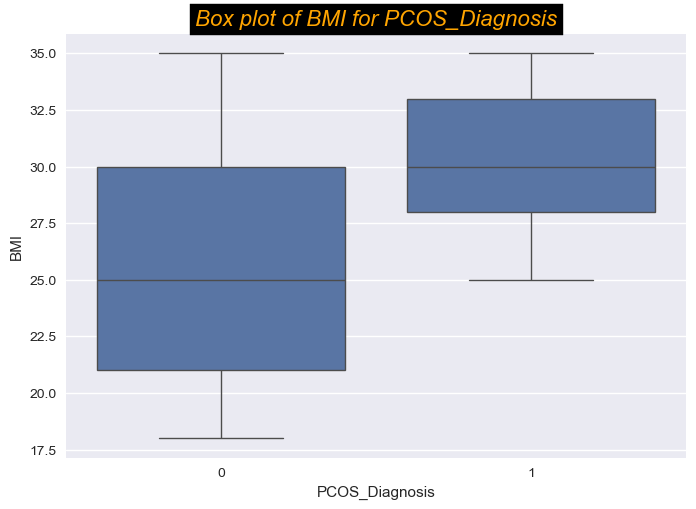

In [19]:
for col in ['Menstrual_Irregularity', 'PCOS_Diagnosis']: # Changed 'PCOS_diagnosis' to 'PCOS_Diagnosis'
    sns.boxplot(data=df, x=col, y='BMI')
    plt.title(f'Box plot of BMI for {col}', fontdict=font)
    plt.show()

## Análisis Multivariable

In [20]:
import plotly.express as px
import plotly.io as pio

# Configura el renderizador predeterminado de Plotly para Colab
pio.renderers.default = 'colab'

# Crea la figura 3D
fig = px.scatter_3d(
    data_frame=df,
    x='Testosterone_Level(ng/dL)',
    y='BMI',
    z='Menstrual_Irregularity',
    color='PCOS_Diagnosis',
    template='ggplot2',
    opacity=0.6,
    height=700,
    title='3d scatter basado en Nivel de testosterona, BMI, Regularidad de Periodo Menstrual y Diagnósticos'
)

# Muestra la figura
fig.show()

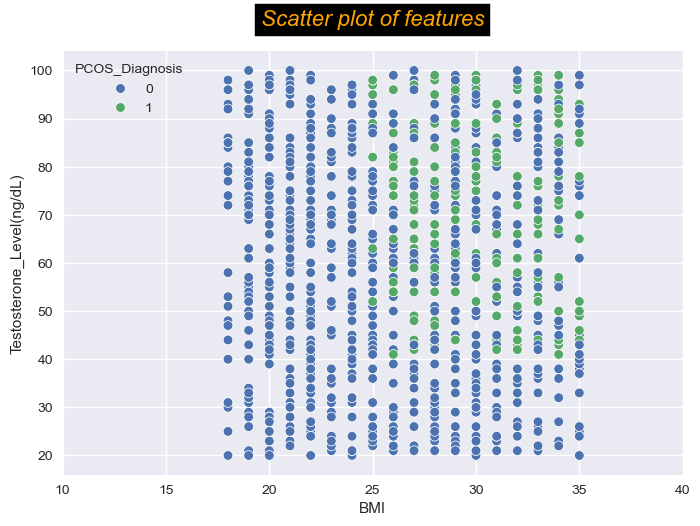

In [21]:
%matplotlib inline
# check feature correlation
sns.scatterplot(data=df,x='BMI', y='Testosterone_Level(ng/dL)', hue='PCOS_Diagnosis',)
plt.title('Scatter plot of features', y=1.04, fontdict=font)
plt.xticks(np.arange(10,45,5))
plt.show()

In [22]:
results=pd.pivot_table(data=df, index='PCOS_Diagnosis', columns='Menstrual_Irregularity', values='BMI')
results.style.background_gradient(cmap='summer_r')

Menstrual_Irregularity,0,1
PCOS_Diagnosis,,
0,26.278132,24.448485
1,31.000000,30.147368


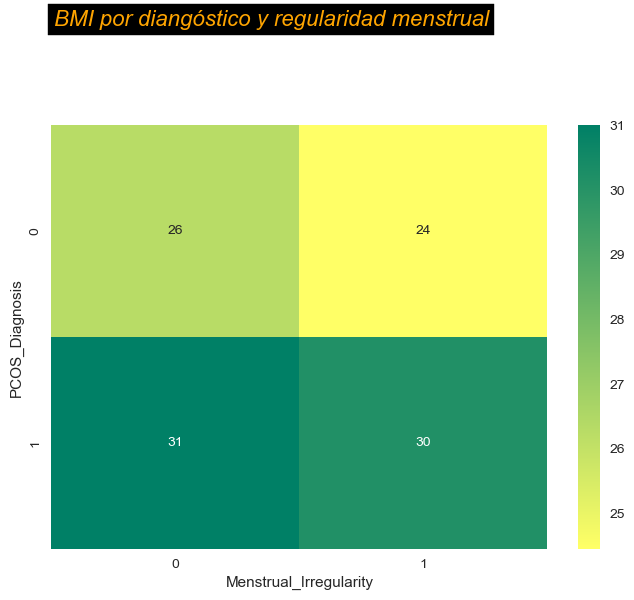

In [23]:
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('BMI por diangóstico y regularidad menstrual', y=1.09, x=0.4, **font)
plt.show()

In [24]:


results=pd.pivot_table(data=df, index='PCOS_Diagnosis', columns='Menstrual_Irregularity', values='Testosterone_Level(ng/dL)')
results.style.background_gradient(cmap='summer_r')
     


Menstrual_Irregularity,0,1
PCOS_Diagnosis,,
0,59.169851,56.075758
1,64.888889,69.778947


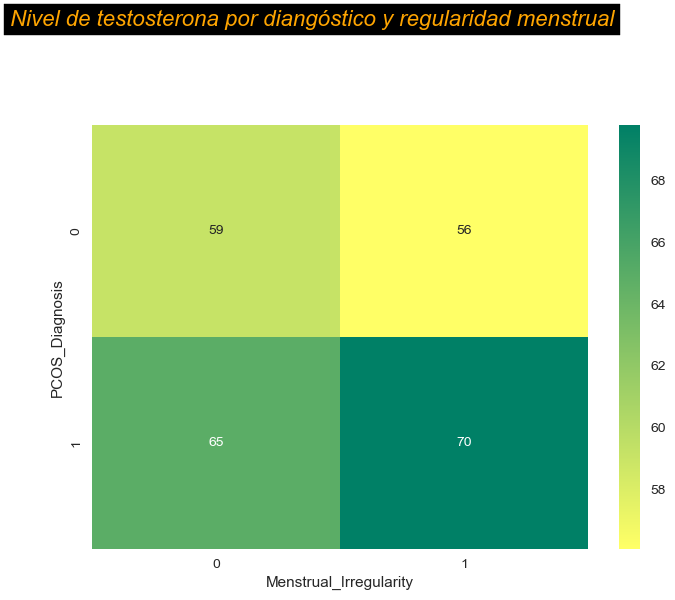

In [25]:
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('Nivel de testosterona por diangóstico y regularidad menstrual', y=1.09, x=0.4, **font)
plt.show()

In [26]:
results=pd.pivot_table(data=df, index='PCOS_Diagnosis', columns='Menstrual_Irregularity', values='Age')
results.style.background_gradient(cmap='summer_r')

Menstrual_Irregularity,0,1
PCOS_Diagnosis,,
0,31.452229,32.887879
1,33.555556,30.536842


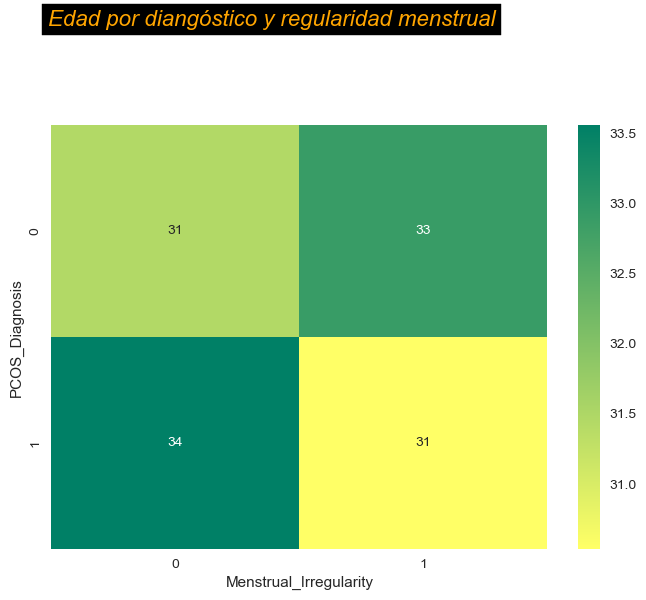

In [27]:
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('Edad por diangóstico y regularidad menstrual', y=1.09, x=0.4, **font)
plt.show()
     

In [28]:
results=pd.pivot_table(data=df, index='PCOS_Diagnosis', columns='Menstrual_Irregularity', values='Antral_Follicle_Count')
results.style.background_gradient(cmap='summer_r')
     

Menstrual_Irregularity,0,1
PCOS_Diagnosis,,
0,17.210191,16.196970
1,20.888889,20.157895


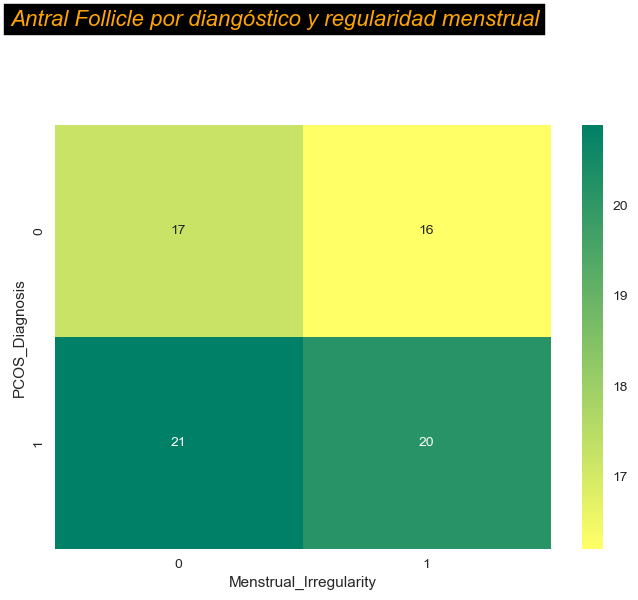

In [29]:
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('Antral Follicle por diangóstico y regularidad menstrual', y=1.09, x=0.4, **font)
plt.show()
     

# Visualizacion de datos

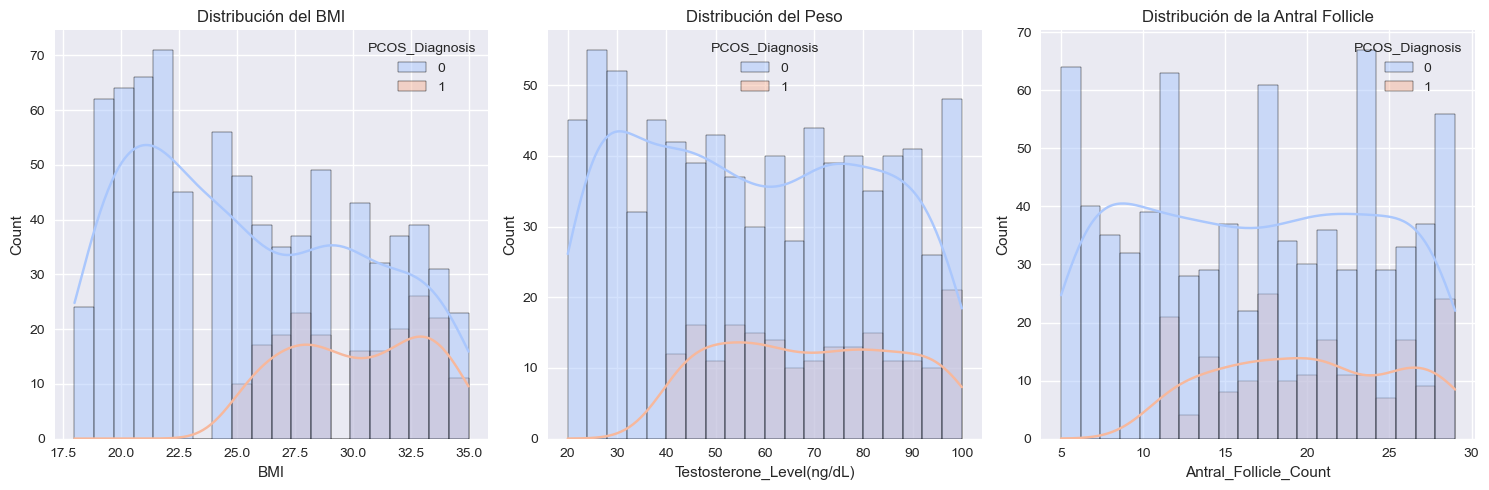

In [30]:
#Graficamos .a distribucion de cada característica
plt.figure(figsize=(15, 5))

#Histograma de BMI
plt.subplot(1, 3, 1)
sns.histplot(df, x="BMI", hue="PCOS_Diagnosis", kde=True, bins=20, palette="coolwarm")
plt.title("Distribución del BMI")

#Histograma de testosterona
plt.subplot(1, 3, 2)
sns.histplot(df, x="Testosterone_Level(ng/dL)", hue="PCOS_Diagnosis", kde=True, bins=20, palette="coolwarm")
plt.title("Distribución del Peso")

#Histograma de edad
plt.subplot(1, 3, 3)
sns.histplot(df, x="Antral_Follicle_Count", hue="PCOS_Diagnosis", kde=True, bins=20, palette="coolwarm")
plt.title("Distribución de la Antral Follicle")

plt.tight_layout()
plt.show()
     

# División en conjunto entrenamiento y prueba

In [31]:
#Definimos características y etiquetas
X = df[['BMI', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count','Age']]
y = df['PCOS_Diagnosis']

#Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, random_state = 42)
     

# Entrenamiento del modelo de Naive Bayes

In [32]:
#Creamos el modelo
modelo = GaussianNB()

#Entrenamos el modelo con los datos
modelo.fit(X_train, y_train)
     

GaussianNB()

# Predicciones y evaluación

In [33]:
#Realizamos predicciones en el conjunto de pruebas
y_pred = modelo.predict(X_test)

#Calculamos la exactitud
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud del modelo: {accuracy}')

#Matriz de confuion
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de confusion: \n', conf_matrix)

#Reporte de clasificacion
print('Reporte de clasificacion: \n', classification_report(y_test, y_pred))

Exactitud del modelo: 0.84375
Matriz de confusion: 
 [[122   8]
 [ 17  13]]
Reporte de clasificacion: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       130
           1       0.62      0.43      0.51        30

    accuracy                           0.84       160
   macro avg       0.75      0.69      0.71       160
weighted avg       0.83      0.84      0.83       160



# Matriz de confusión

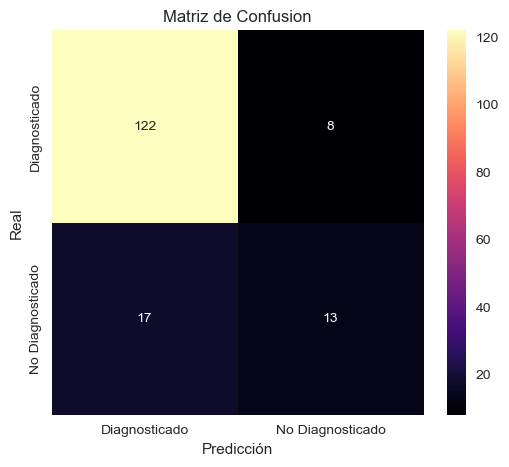

In [34]:
#Graficamos la matriz de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=['Diagnosticado', 'No Diagnosticado'], yticklabels=['Diagnosticado', 'No Diagnosticado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion')
plt.show()
     



    Verdaderos Positivos (TP): 122 (Casos correctamente diagnosticados como positivos)
    Falsos Negativos (FN): 8 (Casos diagnosticados como negativos, pero que realmente eran positivos)
    Falsos Positivos (FP): 17 (Casos diagnosticados como positivos, pero que realmente eran negativos)
    Verdaderos Negativos (TN): 13 (Casos correctamente diagnosticados como negativos)

